## Предсказание жилых зданий


In [2]:
import pandas as pd
import geopandas as gpd

from floor_predictior.osm_living_predictor import (
    BoundaryFetcher, 
    BuildingProcessor,
    RoadProcessor,
    AmenityProcessor,
    FeatureBuilder,
    ModelHandler
    )

from floor_predictior.utils.IsLivingChecker import IsLivingAnnotator

In [ ]:
import os
import pickle
import pandas as pd
import geopandas as gpd
from tqdm import tqdm  # для прогресс-бара (необязательно, но удобно)

# Папка для сохранения промежуточных файлов
PICKLE_DIR = "data/district_parts"
os.makedirs(PICKLE_DIR, exist_ok=True)

districts = [1114193, 1114252, 1114354, 1114806, 1114809, 337424, 1114895, 363103, 1115082, 1115366, 338636, 368287, 
             1114905, 367375, 1115367, 338635, 369514, 1114902, 1482451, 1285772, 1281563, 407876, 3536492, 930950, 
             1761428, 1312868, 7226665, 389790, 1701435, 1926754, 253820]

parts = []

for district in tqdm(districts, desc="Processing districts"):
    try:
        # Имя файла для сохранения
        filename = os.path.join(PICKLE_DIR, f"district_{district}.pkl")
        
        # Попробуем загрузить уже обработанный район, если он есть
        if os.path.exists(filename):
            try:
                with open(filename, 'rb') as f:
                    gdf_with_labels = pickle.load(f)
                print(f"Loaded cached data for district {district}")
                parts.append(gdf_with_labels)
                continue  # переходим к следующему, если успешно загружен
            except Exception as e:
                print(f"Error loading cached data for district {district}: {e}. Recomputing...")

        # Если нет кэша или ошибка при загрузке — пересчитываем
        downloader = BoundaryFetcher()
        bounds = downloader.by_osmid(district, 'R')

        tags_list = [
            'religious', 'recreation_ground',
            'residential', 'commercial',
            'cemetery', 'construction',
            'farmland', 'farmyard',
            'forest', 'military'
        ]

        buildings = BuildingProcessor(bounds)
        buildings_gdf = buildings.load_buildings()
        lu = buildings.load_landuse()
        merged_lu = buildings.merge_landuse(tags_list=tags_list)
        rp = RoadProcessor(bounds=bounds, buildings=buildings_gdf, radius_list=[30, 60, 90], local_crs=buildings.local_crs)
        roads = rp.load_roads()
        rp._buffer_roads()
        rp._join_buildings_to_buffers()
        features_df = rp.build_feature_table()

        ap = AmenityProcessor(bounds=bounds, base_gdf=features_df, radii=[30, 60, 90], local_crs=buildings.local_crs)
        feat_with_amenities = ap.run()

        builder = FeatureBuilder(feat_with_amenities)
        data = builder.build_features()

        annotator = IsLivingAnnotator(data, local_crs=buildings.local_crs, match_strategy="iou", iou_threshold=0.3)
        gdf_with_labels = annotator.annotate()
        gdf_with_labels.to_crs(4326, inplace=True)

        # Сохраняем в pickle
        with open(filename, 'wb') as f:
            pickle.dump(gdf_with_labels, f)
        print(f"Saved district {district} to {filename}")

        parts.append(gdf_with_labels)

    except Exception as e:
        print(f"Failed to process district {district}: {e}")
        continue  # пропускаем, если ошибка

# Объединение всех частей
if parts:
    full_gdf = pd.concat(parts, ignore_index=True)
    full_gdf = gpd.GeoDataFrame(full_gdf, geometry="geometry", crs=parts[0].crs)
else:
    print("No districts were successfully processed.")
    full_gdf = gpd.GeoDataFrame()

In [ ]:
full_gdf = pd.read_pickle("data/processed_data_spb.pkl")

In [ ]:
data = full_gdf.copy()

In [ ]:
data = data.select_dtypes(include=['number']).drop(columns=['id'])
data.dropna(inplace=True)

In [ ]:
# Создание модели
from sklearn.ensemble import RandomForestClassifier

external_model = RandomForestClassifier(random_state=42)
handler = ModelHandler("floor_predictior/model/model_dt.pkl", df=data, target_col="is_living")
handler.set_model(external_model)

X_train, X_test, y_train, y_test = handler.train_test_split()
handler.train_model(X_train, y_train, save=True)

predicted = handler.predict(X_test, map_labels=True)


In [ ]:
predict_data = full_gdf[full_gdf['is_living'].isna()].copy()
predict_data = predict_data.select_dtypes(include=['number']).drop(columns=['id'])

In [ ]:
# Загрузка модели

handler = ModelHandler("model/model_dt.pkl", df=predict_data, target_col="is_living")
handler.load_model_from_file()

predicted = handler.predict(predict_data, map_labels=False)

In [ ]:
predict_data['is_living'] = predicted['predicted']
# predict_data.to_pickle('processeed_data.pkl')

## Предсказание этажности


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from floor_predictior.osm_height_predictor.geo import (BuildingPreprocessor, 
                                GeometryFeatureGenerator, 
                                SpatialStatisticsComputer, 
                                SpatialNeighborhoodAnalyzer, 
                                StoreyModelTrainer)

In [3]:
# Define the folder path
folder_path = "data/"
pkl_files = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith(".pkl")
]

df_list = [pd.read_pickle(f).to_crs(4326) for f in pkl_files]
df_building = (
    pd.concat(df_list, ignore_index=True)
    .rename(columns={"building:levels": "storey"})
    .dropna(subset=["storey"])
    .select_dtypes(exclude=['object', 'string'])
    .drop(columns=['id'])
)

df_building["storey"] = df_building["storey"].astype(int)

df_building = df_building[df_building["is_living"] == 1].reset_index(drop=True)
df_building = df_building[(df_building["storey"] > 2)]

In [4]:
# 1. Предобработка
prep = BuildingPreprocessor(df_building)
prep.filter_residential()
df = prep.get()

In [5]:
# 2. Геометрические признаки
geo_gen = GeometryFeatureGenerator(df)
df = geo_gen.compute_geometry_features()

In [6]:
# 3. Пространственный анализ
stats = SpatialStatisticsComputer(df)
df, global_moran, lisa = stats.compute_moran_and_lisa(col="storey")

In [ ]:
# 4. Соседние признаки
analyzer = SpatialNeighborhoodAnalyzer(df)
df, artifacts = analyzer.compute_neighborhood_metrics(plot=False)

In [ ]:
# 5. Обучение модели
trainer = StoreyModelTrainer(df)
X_train, X_test, y_train, y_test = trainer.prepare_data()
param_dist = {"n_estimators": [100],
              "min_samples_split": [4],
              "min_samples_leaf": [2],
}
model = trainer.train_rf(X_train, y_train, param_dist=param_dist)
trainer.save_model('model/StoreyModelTrainer.joblib')

In [24]:
trainer = StoreyModelTrainer(df).load_model(path='model/StoreyModelTrainer.joblib')


In [21]:
y_pred = trainer.predict(X_test)

## Plot

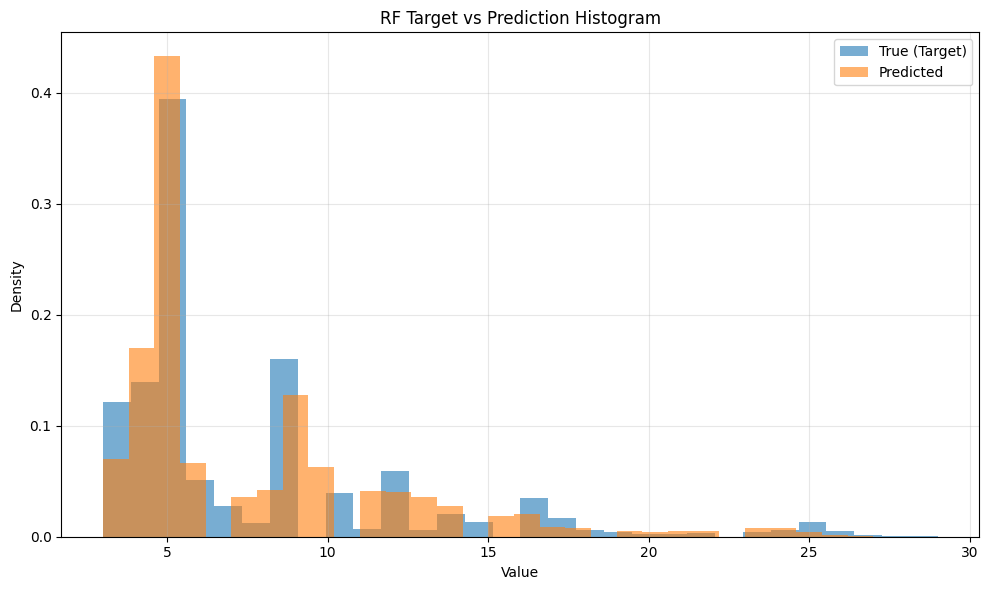

In [22]:
import numpy as np

b_gem = df.to_crs(3857).centroid.copy()

def plot_target_vs_prediction(
    y_true, y_pred, bins=30, title="RF Target vs Prediction Histogram"
):
    plt.figure(figsize=(10, 6))
    plt.hist(y_true, bins=bins, alpha=0.6, label="True (Target)", density=True)
    plt.hist(y_pred, bins=bins, alpha=0.6, label="Predicted", density=True)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_target_vs_prediction(y_test, np.round(y_pred))